# NOAA Multi-Radar / Multi-Sensor System (MRMS) Ingest 

The [NOAA Multi-Radar / Multi-Sensor System (MRMS)](https://www.nssl.noaa.gov/projects/mrms/) was created to produce products of preciptiation impacts on transportation and aviation. 

Using the [NOAA MRMS AWS Bucket](https://aws.amazon.com/marketplace/pp/prodview-6odvdc4md2jjc), this notebook details creation of quicklooks to investigate multisensor (radar, rain gauge, etc) precipitation estimates for Chicago. 

In [31]:
import cfgrib
import xarray as xr
import fsspec
import glob
import tempfile
import io
import gzip
import geopandas as gpd
import pandas as pd

from cartopy import crs as ccrs, feature as cfeature
from matplotlib import pyplot as plt

from metpy.plots import USCOUNTIES

In [2]:
# Define a Date for Analysis [YYYYMMDD format]
DATE = "20240613"

In [3]:
## Setup the AWS S3 filesystem
fs = fsspec.filesystem("s3", anon=True)

## Selecting the Desired MRMS Product

In [4]:
products = ['PrecipFlag_00.00', 'PrecipRate_00.00', 'MultiSensor_QPE_01H_Pass1_00.00']

In [5]:
file_path = sorted(fs.glob(f"s3://noaa-mrms-pds/CONUS/MultiSensor_QPE_01H_Pass1_00.00/{DATE}/*"))

In [6]:
file_path

['noaa-mrms-pds/CONUS/MultiSensor_QPE_01H_Pass1_00.00/20240613/MRMS_MultiSensor_QPE_01H_Pass1_00.00_20240613-000000.grib2.gz',
 'noaa-mrms-pds/CONUS/MultiSensor_QPE_01H_Pass1_00.00/20240613/MRMS_MultiSensor_QPE_01H_Pass1_00.00_20240613-010000.grib2.gz',
 'noaa-mrms-pds/CONUS/MultiSensor_QPE_01H_Pass1_00.00/20240613/MRMS_MultiSensor_QPE_01H_Pass1_00.00_20240613-020000.grib2.gz',
 'noaa-mrms-pds/CONUS/MultiSensor_QPE_01H_Pass1_00.00/20240613/MRMS_MultiSensor_QPE_01H_Pass1_00.00_20240613-030000.grib2.gz',
 'noaa-mrms-pds/CONUS/MultiSensor_QPE_01H_Pass1_00.00/20240613/MRMS_MultiSensor_QPE_01H_Pass1_00.00_20240613-040000.grib2.gz',
 'noaa-mrms-pds/CONUS/MultiSensor_QPE_01H_Pass1_00.00/20240613/MRMS_MultiSensor_QPE_01H_Pass1_00.00_20240613-050000.grib2.gz',
 'noaa-mrms-pds/CONUS/MultiSensor_QPE_01H_Pass1_00.00/20240613/MRMS_MultiSensor_QPE_01H_Pass1_00.00_20240613-060000.grib2.gz',
 'noaa-mrms-pds/CONUS/MultiSensor_QPE_01H_Pass1_00.00/20240613/MRMS_MultiSensor_QPE_01H_Pass1_00.00_20240613-07

In [7]:
with fs.open(file_path[-2], 'rb') as gzip_file:
    print(gzip_file)
    #compressed_file = gzip_file.read()
    #compressed_file = io.BytesIO(gzip_file)
    #print(compressed_file)
    with tempfile.NamedTemporaryFile(suffix=".grib2") as f:
        f.write(gzip.decompress(gzip_file.read()))
        xx = xr.load_dataset(f.name)

<File-like object S3FileSystem, noaa-mrms-pds/CONUS/MultiSensor_QPE_01H_Pass1_00.00/20240613/MRMS_MultiSensor_QPE_01H_Pass1_00.00_20240613-220000.grib2.gz>


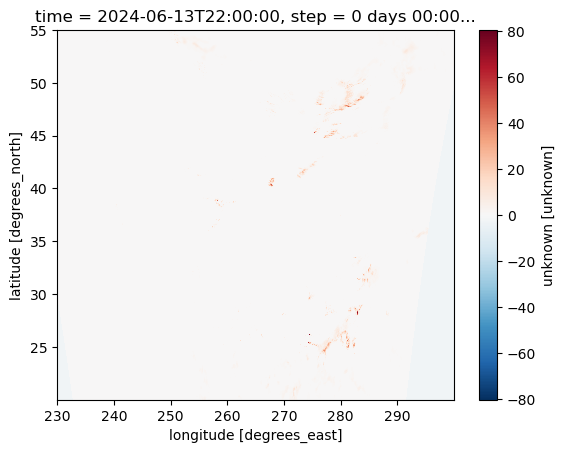

In [8]:
xx.unknown.plot()

In [9]:
xx

<xarray.Dataset> Size: 98MB
Dimensions:         (latitude: 3500, longitude: 7000)
Coordinates:
    time            datetime64[ns] 8B 2024-06-13T22:00:00
    step            timedelta64[ns] 8B 00:00:00
    heightAboveSea  float64 8B 0.0
  * latitude        (latitude) float64 28kB 54.99 54.98 54.98 ... 20.02 20.01
  * longitude       (longitude) float64 56kB 230.0 230.0 230.0 ... 300.0 300.0
    valid_time      datetime64[ns] 8B 2024-06-13T22:00:00
Data variables:
    unknown         (latitude, longitude) float32 98MB 0.0 0.0 0.0 ... -3.0 -3.0
Attributes:
    GRIB_edition:            2
    GRIB_centre:             161
    GRIB_centreDescription:  US NOAA Office of Oceanic and Atmospheric Research
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US NOAA Office of Oceanic and Atmospheric Research
    history:                 2024-07-19T16:45 GRIB to CDM+CF via cfgrib-0.9.1...

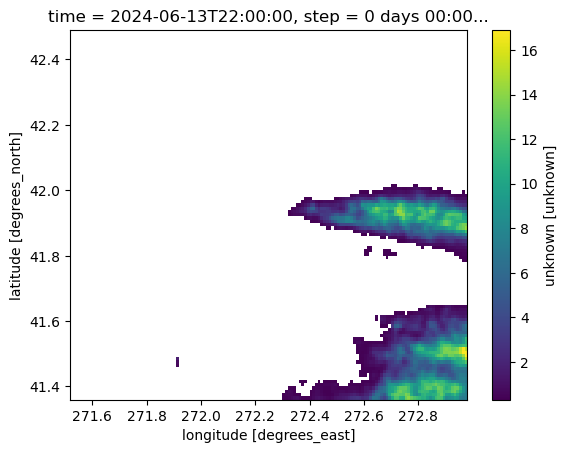

In [10]:
xx.sel(latitude=slice(42.493302, 41.356063), longitude=slice(271.52, 272.98)).where(xx.unknown > 0).unknown.plot()

## Read the File

In [11]:
chicago_domain = [-88.474769, -87.020042, 41.356063, 42.493302]

(41.356063, 42.493302)

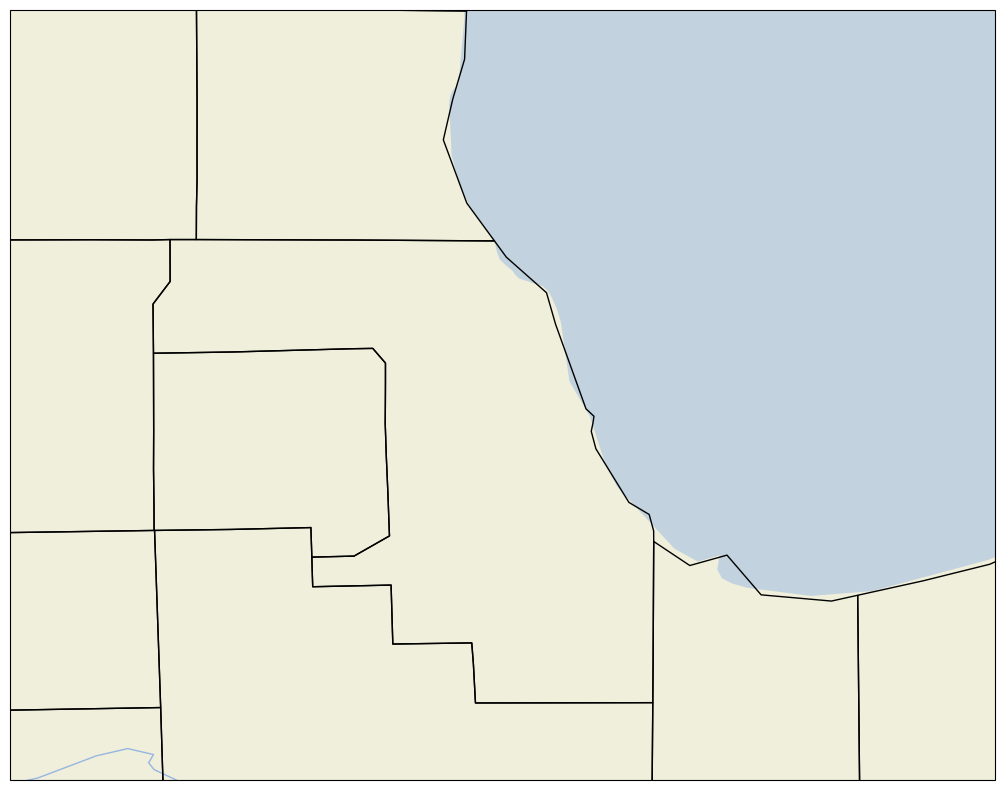

In [18]:
##fig = plt.figure(figsize=(14, 6))
##ax = figure.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
##ax.set_global()

figure = plt.figure(figsize=(16, 10))
ax = figure.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    
#ax.add_feature(cfeature.COASTLINE)
#ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND)
#ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(USCOUNTIES)

#xx.sel(latitude=slice(42.493302, 41.356063), longitude=slice(271.52, 272.98)).unknown.plot(ax=ax, 
#                                                                                           transform=ccrs.PlateCarree(), 
#                                                                                          x="latitude", 
#                                                                                           y="longitude", 
#                                                                                           add_colorbar=False
#)
#ax.coastlines()
ax.set_xlim([chicago_domain[0], chicago_domain[1]])
ax.set_ylim([chicago_domain[2], chicago_domain[3]])
#ax.set_ylim([0, 90]);

In [19]:
import geopandas as gpd
import matplotlib.pyplot as plt

In [20]:
# Read the ShapeFile
gdf = gpd.read_file("/Users/jrobrien/Downloads/CROCUS_Boundaries/geo_export_ef36ca5a-9334-4c53-a951-39ab84f50ed3.shp")

In [21]:
gdf

,area,area_num_1,area_numbe,comarea,comarea_id,community,perimeter,shape_area,shape_len,geometry
0,0.0,35,35,0.0,0.0,DOUGLAS,0.0,4.600462e+07,31027.054510,"POLYGON ((-87.60914 41.84469, -87.60915 41.844..."
1,0.0,36,36,0.0,0.0,OAKLAND,0.0,1.691396e+07,19565.506153,"POLYGON ((-87.59215 41.81693, -87.59231 41.816..."
2,0.0,37,37,0.0,0.0,FULLER PARK,0.0,1.991670e+07,25339.089750,"POLYGON ((-87.6288 41.80189, -87.62879 41.8017..."
3,0.0,38,38,0.0,0.0,GRAND BOULEVARD,0.0,4.849250e+07,28196.837157,"POLYGON ((-87.60671 41.81681, -87.6067 41.8165..."
4,0.0,39,39,0.0,0.0,KENWOOD,0.0,2.907174e+07,23325.167906,"POLYGON ((-87.59215 41.81693, -87.59215 41.816..."
...,...,...,...,...,...,...,...,...,...,...
72,0.0,74,74,0.0,0.0,MOUNT GREENWOOD,0.0,7.558429e+07,48665.130539,"POLYGON ((-87.69646 41.70714, -87.69644 41.706..."
73,0.0,75,75,0.0,0.0,MORGAN PARK,0.0,9.187734e+07,46396.419362,"POLYGON ((-87.64215 41.68508, -87.64249 41.685..."
74,0.0,76,76,0.0,0.0,OHARE,0.0,3.718356e+08,173625.984660,"MULTIPOLYGON (((-87.83658 41.9864, -87.83658 4..."
75,0.0,77,77,0.0,0.0,EDGEWATER,0.0,4.844999e+07,31004.830946,"POLYGON ((-87.65456 41.99817, -87.65456 41.998..."


In [23]:
type(gdf)

geopandas.geodataframe.GeoDataFrame

<Axes: >

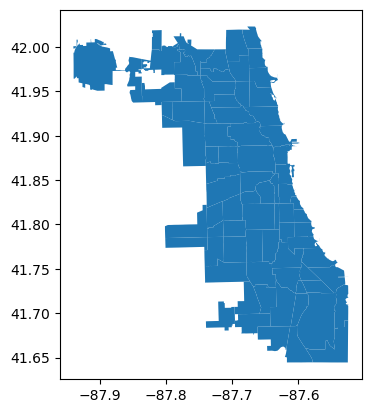

In [22]:
gdf.plot()

In [28]:
date_selection = "07/15/2024"
file_sat2 = f'http://data.cocorahs.org/export/exportreports.aspx?ReportType=Daily&dtf=1&Format=CSV&State=IL&County=CK&ReportDateType=reportdate&Date={date_selection}&TimesInGMT=True'

In [29]:
file_sat2

'http://data.cocorahs.org/export/exportreports.aspx?ReportType=Daily&dtf=1&Format=CSV&State=IL&County=CK&ReportDateType=reportdate&Date=07/15/2024&TimesInGMT=True'

In [32]:
df = pd.read_csv(file_sat2)

In [33]:
df

,ObservationDate,ObservationTime,EntryDateTime,StationNumber,StationName,Latitude,Longitude,TotalPrecipAmt,NewSnowDepth,NewSnowSWE,TotalSnowDepth,TotalSnowSWE,DateTimeStamp
0,2024-07-15,12:30 PM,2024-07-15 12:27 PM,IL-CK-12,Bridgeview 1.3 NNW,41.755015,-87.817285,0.96,NA,NA,NA,NA,2024-07-15 12:27 PM
1,2024-07-15,12:00 PM,2024-07-15 12:20 PM,IL-CK-14,Chicago 5.5 ESE,41.800772,-87.590335,0.93,NA,NA,NA,NA,2024-07-15 12:20 PM
2,2024-07-15,11:00 AM,2024-07-15 11:32 AM,IL-CK-50,Palos Park 1.3 SW,41.652814,-87.863067,1.39,NA,NA,NA,NA,2024-07-15 11:32 AM
3,2024-07-15,12:27 PM,2024-07-15 01:01 PM,IL-CK-53,Glencoe 0.1 NW,42.135650,-87.765394,1.44,NA,NA,NA,NA,2024-07-15 01:01 PM
4,2024-07-15,12:00 PM,2024-07-15 12:14 PM,IL-CK-61,Oak Park 1.0 SW,41.875580,-87.801110,0.88,NA,NA,NA,NA,2024-07-15 12:13 PM
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,2024-07-15,12:00 PM,2024-07-15 12:20 PM,IL-CK-306,Oak Forest 0.6 N,41.615500,-87.750700,1.13,0.0,NA,0.0,NA,2024-07-15 12:19 PM
57,2024-07-15,12:00 PM,2024-07-15 12:41 PM,IL-CK-131,Schaumburg 2.0 E,42.030278,-88.043989,1.25,NA,NA,NA,NA,2024-07-15 12:40 PM
58,2024-07-15,12:00 PM,2024-07-15 12:46 PM,IL-CK-394,Burr Ridge 0.5 SE,41.745055,-87.914698,1.23,NA,NA,NA,NA,2024-07-15 12:45 PM
59,2024-07-15,01:00 PM,2024-07-15 01:14 PM,IL-CK-406,Palatine 1.5 NE,42.130082,-88.026691,1.87,NA,NA,NA,NA,2024-07-15 01:13 PM


In [34]:
# Interpolate the data to create a grid for contour plotting
lon = df['Longitude'].values
lat = df['Latitude'].values
precip = df['TotalPrecipAmt'].values

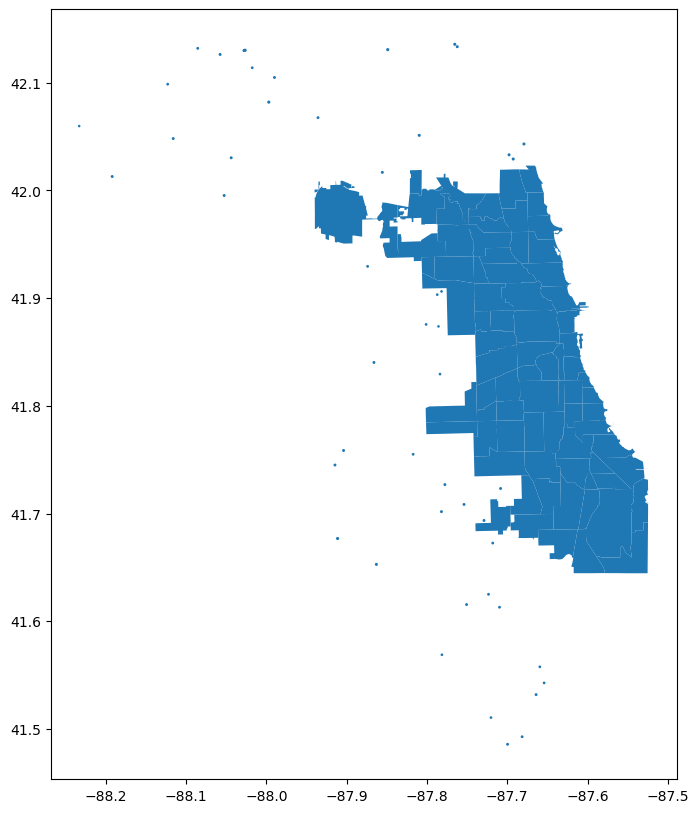

In [38]:
##fig = plt.figure(figsize=(14, 6))
##ax = figure.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
##ax.set_global()

figure = plt.figure(figsize=(16, 10))
ax = figure.add_subplot(1, 1, 1)
    
#ax.add_feature(cfeature.COASTLINE)
#ax.add_feature(cfeature.STATES)
#ax.add_feature(cfeature.BORDERS, linestyle=':')
#ax.add_feature(cfeature.LAND)
#ax.add_feature(cfeature.OCEAN)
#ax.add_feature(cfeature.LAKES, alpha=0.5)
#ax.add_feature(cfeature.RIVERS)
#ax.add_feature(USCOUNTIES)

#xx.sel(latitude=slice(42.493302, 41.356063), longitude=slice(271.52, 272.98)).unknown.plot(ax=ax, 
#                                                                                           transform=ccrs.PlateCarree(), 
#                                                                                          x="latitude", 
#                                                                                           y="longitude", 
#                                                                                           add_colorbar=False
#)
#ax.coastlines()

gdf.plot(ax=ax)
ax.scatter(lon, lat, precip)

#ax.set_xlim([chicago_domain[0], chicago_domain[1]])
#ax.set_ylim([chicago_domain[2], chicago_domain[3]])
#ax.set_ylim([0, 90]);